# Using the total_points dataset to determine goalie rankings

In [1]:
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler


In [2]:
#Import goalie-specific, model ready csv

all_goalies = pd.read_csv("C:/Users/Daniel Quinn/Desktop/Bootcamp/Project_2/data/processed/end_cost_predictions_df_master.csv")

#Ensure we can read the whole dataframe, without "..."
pd.set_option("display.max_rows", None)
all_goalies = all_goalies.drop(columns = ['Unnamed: 0'])
all_goalies.head()


,id,first_name,second_name,team,element_type,code,element_code,season,total_points,minutes,...,ict_index,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,Saves_Percentage,start_cost,end_cost,Predicted_End_Cost
0,15,David,Raya Martin,1,1,154561,154561,2021,95,2160,...,60.1,0,0.00,0.00,0.00,0.00,74.285714,45,44,45.376
1,15,David,Raya Martin,1,1,154561,154561,2022,166,3420,...,117.3,38,0.11,0.12,0.23,50.12,77.000000,45,48,49.154
2,15,David,Raya Martin,1,1,154561,154561,2023,135,2880,...,41.1,32,0.00,0.04,0.04,22.51,66.197183,50,53,54.892
3,73,Norberto,Murara Neto,1,1,69752,69752,2022,93,2385,...,72.8,27,0.00,0.02,0.02,44.70,71.942446,45,45,44.196
4,73,Norberto,Murara Neto,1,1,69752,69752,2023,110,2880,...,87.5,32,0.00,0.01,0.01,49.66,67.455621,45,46,46.408


In [3]:
#Create Saves Percentage stat to screen irrelevant players via a dropna():
all_goalies_dropna = all_goalies
all_goalies_dropna["Saves_Percentage"] = (all_goalies['saves'] + all_goalies['penalties_saved']) / (all_goalies['saves'] + all_goalies['penalties_saved'] + all_goalies['goals_conceded']) * 100
#pd.set_option("display.max_columns", None)
all_goalies_dropna = all_goalies.dropna()
all_goalies_dropna.shape


(181, 35)

In [4]:
#Create a better dataframe name for going forward

#goalie_hist_model_2_ready 
goalie_hist_model_1 = all_goalies_dropna
goalie_hist_model_1.columns

Index(['id', 'first_name', 'second_name', 'team', 'element_type', 'code',
       'element_code', 'season', 'total_points', 'minutes', 'goals_scored',
       'assists', 'clean_sheets', 'goals_conceded', 'own_goals',
       'penalties_saved', 'penalties_missed', 'yellow_cards', 'red_cards',
       'saves', 'bonus', 'bps', 'influence', 'creativity', 'threat',
       'ict_index', 'starts', 'expected_goals', 'expected_assists',
       'expected_goal_involvements', 'expected_goals_conceded',
       'Saves_Percentage', 'start_cost', 'end_cost', 'Predicted_End_Cost'],
      dtype='object')

In [5]:
#Check the p-value to determine the statistical significance of each features

goalie_hist_model_2 = goalie_hist_model_1[['minutes', 'total_points', 'clean_sheets', 'goals_conceded',
                                                       'saves', 'ict_index', 'bonus', 'bps',
                                                       'expected_goals_conceded', 'starts', 'penalties_saved', 'expected_goal_involvements',
                                                       'assists', 'own_goals', 'end_cost']]

import statsmodels.api as sm

#create X & y variables
X = goalie_hist_model_2.drop(columns = ['end_cost'])
y = goalie_hist_model_2['end_cost']

#test-training split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Use the statsmodels package to create and fit a linear regression
lr = sm.OLS(y_train, X_train).fit()
lr.pvalues.sort_values(ascending=False)

minutes                       0.952519
expected_goal_involvements    0.784980
ict_index                     0.726721
bps                           0.713543
starts                        0.637350
expected_goals_conceded       0.519998
goals_conceded                0.474923
penalties_saved               0.470761
clean_sheets                  0.431686
saves                         0.352007
own_goals                     0.321933
bonus                         0.282440
assists                       0.281112
total_points                  0.219594
dtype: float64

# Regressions for total_points

In [6]:
#Linear Regression
# #create X & y variables
X = goalie_hist_model_1[['minutes', 'goals_scored', 'clean_sheets', 'penalties_saved', 
                              'penalties_missed', 'bps', 'bonus', 'yellow_cards',
                              'red_cards', 'own_goals', 'goals_conceded']]
y = goalie_hist_model_1['total_points']

#test-training split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#create model
lr_model = LinearRegression()

lr_model.fit(X_train, y_train)
print("Train model score: ", lr_model.score(X_train, y_train))
print("Test model score: ", lr_model.score(X_test, y_test))

Train model score:  0.9893634268945906
Test model score:  0.9928922028218434


In [7]:
#Make predictions

prediction1 = lr_model.predict(X_test)

#Evaluate models with mse and r2

mse = mean_squared_error(y_test, prediction1) # how close are the predicted values to actual values via the squared differences between expected and real
r2 = r2_score(y_test, prediction1) # r2 - how well do the indep variables explain the variation in the dep var? ) 0 is a perfect model, the larger the nuber, the worse the model is performing

print(f"All Features (Saves_Percentage = y):")
print(f"mean squared error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

All Features (Saves_Percentage = y):
mean squared error (MSE): 21.97171937840257
R-squared (R2): 0.9928922028218434


# RFR
I deleted "minutes" from the below RFR model because it was given way too much importance. With it gone, "saves" moves up dramatically (which makes sense, given that these are goalies...) Doing so made almost no difference in the Linear Regression above.

In [8]:
#Random Forest
# #create X & y variables
X = goalie_hist_model_1[['minutes', 'goals_scored', 'clean_sheets', 'penalties_saved', 
                              'penalties_missed', 'bps', 'bonus', 'yellow_cards',
                              'red_cards', 'own_goals', 'goals_conceded']]
y = goalie_hist_model_1['total_points']

#test-training split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#create & train model
random_forest = RandomForestRegressor(n_estimators=500, random_state=42).fit(X_train, y_train)

# Evaluate the model
print(f"Training Score: {random_forest.score(X_train, y_train)}")
print(f"Testing Score: {random_forest.score(X_test, y_test)}")

Training Score: 0.9961915330083903
Testing Score: 0.9768280660644353


In [9]:
# Feature Importance
feature_importances = random_forest.feature_importances_

feature_importances_df = pd.DataFrame(feature_importances, X.columns)


print(feature_importances_df.sort_values(by=0, ascending=False))



                         0
minutes           0.859602
clean_sheets      0.058745
bps               0.058516
goals_conceded    0.011610
bonus             0.006483
penalties_saved   0.002202
yellow_cards      0.001867
own_goals         0.000443
goals_scored      0.000293
red_cards         0.000240
penalties_missed  0.000000


# Predictions:
There is no difference between the LR & RFR predicted values:

In [10]:
#LR Predict:

predicted_total_points_lr = goalie_hist_model_1[['minutes', 'goals_scored', 'clean_sheets', 'penalties_saved', 
                              'penalties_missed', 'bps', 'bonus', 'yellow_cards',
                              'red_cards', 'own_goals', 'goals_conceded']]

y_new_pred_total_points_lr = lr_model.predict(predicted_total_points_lr)
y_new_pred_total_points_lr

exp_total_points_lr = pd.DataFrame(y_new_pred_total_points_lr)
exp_total_points_lr.head(15)



,0
0,88.418522
1,156.273654
2,140.399451
3,88.518613
4,111.510105
5,13.254059
6,7.222626
7,28.622998
8,181.250025
9,127.273513


In [11]:
#RFR Predict:

predicted_total_points_rfr = goalie_hist_model_1[['minutes', 'goals_scored', 'clean_sheets', 'penalties_saved', 
                              'penalties_missed', 'bps', 'bonus', 'yellow_cards',
                              'red_cards', 'own_goals', 'goals_conceded']]

y_new_pred_total_points_rfr = random_forest.predict(predicted_total_points_rfr)
y_new_pred_total_points_rfr

exp_total_points_rfr = pd.DataFrame(y_new_pred_total_points_rfr)
exp_total_points_rfr.head(15)


,0
0,90.344
1,160.620
2,135.108
3,93.902
4,110.714
5,12.692
6,7.924
7,32.890
8,178.858
9,134.268


In [12]:
# Create new dataframe with expected total_points

total_points_predictions_df_master = goalie_hist_model_1
total_points_predictions_df_master['Predicted_Total_Points'] = exp_total_points_rfr
total_points_predictions_df_master = total_points_predictions_df_master[['id', 'first_name', 'second_name', 'team', 'element_type', 'code',
       'element_code', 'season', 'minutes', 'total_points', 'Predicted_Total_Points']]

total_points_predictions_df_master.head(10)

total_points_predictions_df_master.to_csv("C:/Users/Daniel Quinn/Desktop/Bootcamp/Project_2/data/processed/total_point_predictions_df_master.csv")
total_points_predictions_df_master.sort_values('second_name', ascending=True)
total_points_predictions_df_master.columns


Index(['id', 'first_name', 'second_name', 'team', 'element_type', 'code',
       'element_code', 'season', 'minutes', 'total_points',
       'Predicted_Total_Points'],
      dtype='object')

In [13]:
# Create new dataframe with expected total_points

total_points_predictions_df_master = goalie_hist_model_1
total_points_predictions_df_master['Predicted_Total_Points'] = exp_total_points_rfr
total_points_predictions_df_master = total_points_predictions_df_master[['id', 'first_name', 'second_name', 'team', 'element_type', 'code',
       'element_code', 'season', 'minutes', 'total_points', 'Predicted_Total_Points']]

total_points_predictions_df_master.head(10)

#export to csv
total_points_predictions_df_master.to_csv("C:/Users/Daniel Quinn/Desktop/Bootcamp/Project_2/data/processed/total_point_predictions_df_master.csv")
total_points_predictions_df_master.sort_values('second_name', ascending=True)

#edit dataframe down for final merge
goalie_final_merge = total_points_predictions_df_master[['season', 'first_name', 'second_name', 'Predicted_Total_Points']]
goalie_final_merge = goalie_final_merge[goalie_final_merge['season'] == 2023]
goalie_final_merge.sort_values('Predicted_Total_Points', ascending=False)

#scale data for congruence with Matt's dataset from Sorare
goalie_final_merge["Predicted_Total_Points"] = goalie_final_merge["Predicted_Total_Points"]/2
goalie_final_merge.head()

#export final document for merge into model
goalie_final_merge.to_csv('C:/Users/Daniel Quinn/Desktop/Bootcamp/Project_2/data/processed/goalie_final_merge.csv')

c:\Users\Daniel Quinn\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


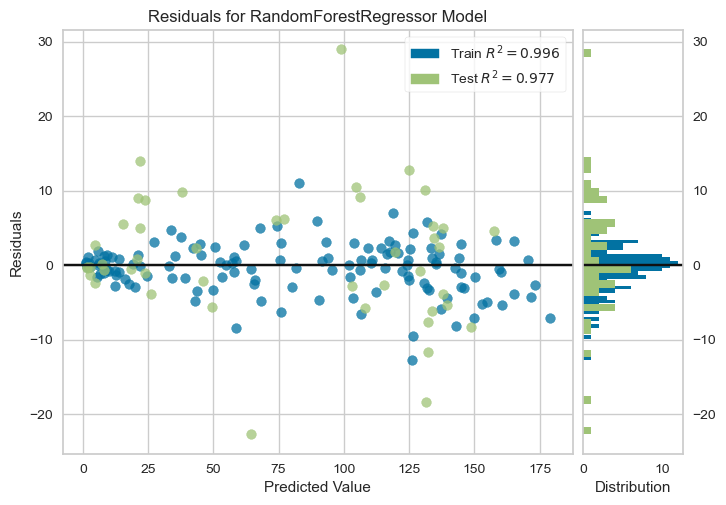

<Axes: title={'center': 'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [14]:
#residuals plot for svm
from yellowbrick.regressor import ResidualsPlot
# Initialize ResidualsPlot
visualizer = ResidualsPlot(random_forest)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()  # Finalize and show the figure

c:\Users\Daniel Quinn\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


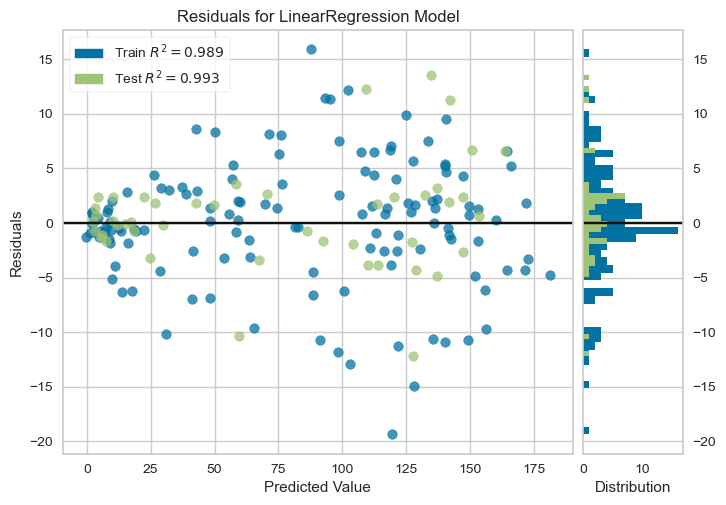

<Axes: title={'center': 'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [15]:
# Initialize ResidualsPlot
visualizer = ResidualsPlot(lr_model)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()  # Finalize and show the figure